In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_c

In [2]:
import pandas as pd
pd.plotting.register_matplotlib_converters()
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
print("Setup Complete")

Setup Complete


In [3]:
from sklearn.model_selection import train_test_split
#Read Train and Test Data
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

y=train_data["Survived"]

# Exploration, Analysis and Feature Engineering

In [4]:
train_data.info()
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass  

In [5]:
print("The shape of train_data:", train_data.shape)
print("The shape of test_data:", test_data.shape)

The shape of train_data: (891, 12)
The shape of test_data: (418, 11)


In [6]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [8]:
columns = train_data.columns
for col in columns:
    print("unique values in {} column is: {}". format(col, train_data[col].value_counts().size))

unique values in PassengerId column is: 891
unique values in Survived column is: 2
unique values in Pclass column is: 3
unique values in Name column is: 891
unique values in Sex column is: 2
unique values in Age column is: 88
unique values in SibSp column is: 7
unique values in Parch column is: 7
unique values in Ticket column is: 681
unique values in Fare column is: 248
unique values in Cabin column is: 147
unique values in Embarked column is: 3


In [9]:
print("Total number of male passengers:")
print(train_data.loc[train_data.Sex=="male"].Sex.size)
print("Total number of female passengers:")
print(train_data.loc[train_data.Sex=="female"].Sex.size)

Total number of male passengers:
577
Total number of female passengers:
314


In [10]:
print("The percentage of survived with respect to Sex:")
print(100 * train_data.groupby("Sex").Survived.mean())

The percentage of survived with respect to Sex:
Sex
female    74.203822
male      18.890815
Name: Survived, dtype: float64


In [11]:
print("The percentage of survived with respect to Pclass:")
print(100 * train_data.groupby("Pclass").Survived.mean())

The percentage of survived with respect to Pclass:
Pclass
1    62.962963
2    47.282609
3    24.236253
Name: Survived, dtype: float64


In [12]:
print("The percentage of survived with respect to Age:")
print(100 * train_data.groupby("Age").Survived.mean())

The percentage of survived with respect to Age:
Age
0.42     100.0
0.67     100.0
0.75     100.0
0.83     100.0
0.92     100.0
         ...  
70.00      0.0
70.50      0.0
71.00      0.0
74.00      0.0
80.00    100.0
Name: Survived, Length: 88, dtype: float64


As you can see it is difficult to grasp an idea about the relation between survived and age features. In this case, data visualization will be used.

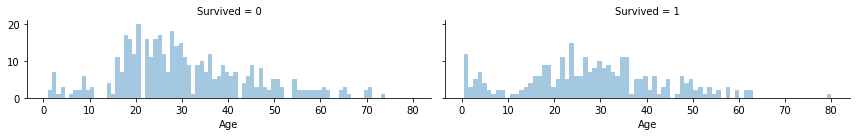

In [13]:
g = sns.FacetGrid(col="Survived", data=train_data, height = 2, aspect=3)
g.map(sns.distplot, "Age", kde=False, bins=80)

The above graph tells us that children had a higher survival chance. To get a more clear prediction, one way is to divide the age feature into categories. pandas.cut() function will be used to achieve this goal. Since xgboost will be used, missing values will not be imputed instead they will be categorized as missing.

In [14]:
def cut_age(df, cut_values, label_names):
    df["Age"] = df["Age"].fillna(-0.5)
    df["Age"]=pd.cut(df["Age"], bins=cut_values, labels=label_names)
    return df
    
cut_values=[-1, 0, 3, 12, 19, 35, 60, 80]
label_names=["Missing", "Infants", "Children", "Teenagers", "Young Adults", "Middle-Age Adults", "Seniors"]
train_data=cut_age(train_data, cut_values, label_names)
test_data=cut_age(test_data, cut_values, label_names)

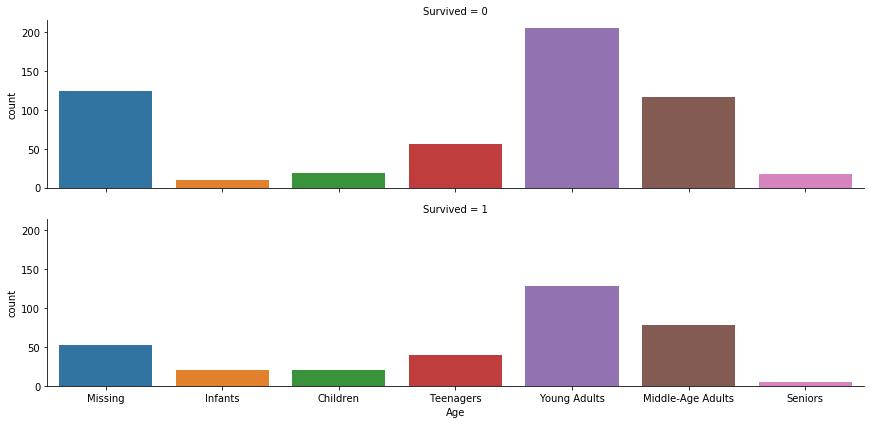

In [15]:
sns.catplot(x="Age", row="Survived", kind="count", height=3, aspect=4, data=train_data)

In [16]:
print(100 * train_data.groupby("Age").Survived.mean())

Age
Missing              29.378531
Infants              66.666667
Children             51.282051
Teenagers            41.052632
Young Adults         38.438438
Middle-Age Adults    40.000000
Seniors              22.727273
Name: Survived, dtype: float64


The results prove that infants and children had survived more than other age groups.

In [17]:
print("The percentage of survived with respect to SibSp:")
print(100 * train_data.groupby("SibSp").Survived.mean())

The percentage of survived with respect to SibSp:
SibSp
0    34.539474
1    53.588517
2    46.428571
3    25.000000
4    16.666667
5     0.000000
8     0.000000
Name: Survived, dtype: float64


In [18]:
print("The percentage of survived with respect to Parch:")
print(100 * train_data.groupby("Parch").Survived.mean())

The percentage of survived with respect to Parch:
Parch
0    34.365782
1    55.084746
2    50.000000
3    60.000000
4     0.000000
5    20.000000
6     0.000000
Name: Survived, dtype: float64


What is interesting in these findings is that it seems that individuals who are alone (no family members) had less chance of survival than if they had 1 to 3 family members on board. But when the family members are more than 3 the survival chance drops. To be more precise, Parch and SibSp featurs will be combined into one feature to indicate the number of family members of each passengers on board. The new feature will be called Fam_membs, and Parch and SibSp features will be dropped.

In [19]:
def Cr_fam_membs(df):
    df["FamMembs"]= df["Parch"] + df["SibSp"]
    df=df.drop(["SibSp", "Parch"], axis=1)
    return df

train_data=Cr_fam_membs(train_data)
test_data=Cr_fam_membs(test_data)

In [20]:
print(100 * train_data.groupby("FamMembs").Survived.mean())

FamMembs
0     30.353818
1     55.279503
2     57.843137
3     72.413793
4     20.000000
5     13.636364
6     33.333333
7      0.000000
10     0.000000
Name: Survived, dtype: float64


To limit the number of categories in Fam_membs features, it will be divided into 4 categories as following:
* IsAlone: 0 fam_membs
* Small family: 1-3 fam_membs
* Meduim family: 4-6 fam_membs
* Large family: 7-10 fam_membs

In [21]:
train_data["FamMembs"].unique()

array([ 1,  0,  4,  2,  6,  5,  3,  7, 10])

In [22]:
test_data["FamMembs"].unique()

array([ 0,  1,  2,  4,  3,  5,  7,  6, 10])

In [23]:
train_data["FamMembs"]=train_data["FamMembs"].apply(lambda s: "IsAlone" if s==0 else s)
train_data["FamMembs"]=train_data["FamMembs"].apply(lambda s: "Small family" if (s==1 or s==2 or s==3) else s)
train_data["FamMembs"]=train_data["FamMembs"].apply(lambda s: "Meduim family" if (s==4 or s==5 or s==6) else s)
train_data["FamMembs"]=train_data["FamMembs"].apply(lambda s: "Large family" if (s==7 or s==10) else s)

In [24]:
test_data["FamMembs"]=test_data["FamMembs"].apply(lambda s: "IsAlone" if s==0 else s)
test_data["FamMembs"]=test_data["FamMembs"].apply(lambda s: "Small family" if (s==1 or s==2 or s==3) else s)
test_data["FamMembs"]=test_data["FamMembs"].apply(lambda s: "Meduim family" if (s==4 or s==5 or s==6) else s)
test_data["FamMembs"]=test_data["FamMembs"].apply(lambda s: "Large family" if (s==7 or s==10) else s)

In [25]:
train_data["FamMembs"].value_counts()

IsAlone          537
Small family     292
Meduim family     49
Large family      13
Name: FamMembs, dtype: int64

In [26]:
test_data["FamMembs"].value_counts()

IsAlone          253
Small family     145
Meduim family     14
Large family       6
Name: FamMembs, dtype: int64

In [27]:
print("The percentage of survived with respect to Fam_membs:")
print(100 * train_data.groupby("FamMembs").Survived.mean())

The percentage of survived with respect to Fam_membs:
FamMembs
IsAlone          30.353818
Large family      0.000000
Meduim family    20.408163
Small family     57.876712
Name: Survived, dtype: float64


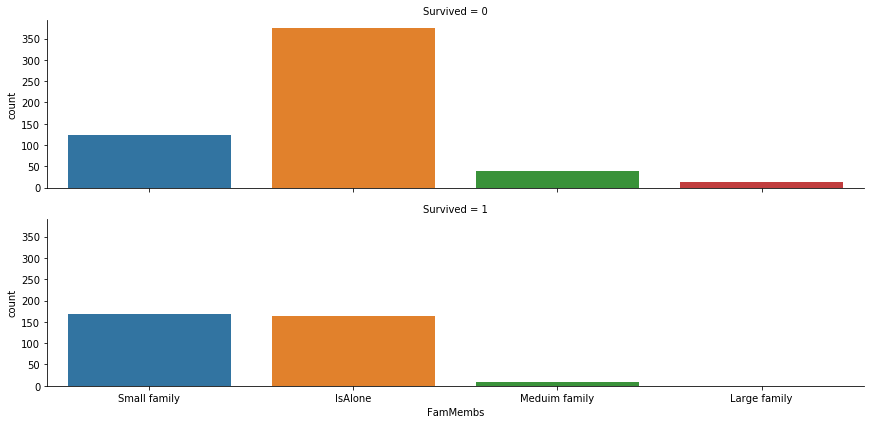

In [28]:
sns.catplot(x="FamMembs", row="Survived", kind="count", height=3, aspect=4, data=train_data)

In [29]:
print("The percentage of survived with respect to Embarked:")
print(100 * train_data.groupby("Embarked").Survived.mean())

The percentage of survived with respect to Embarked:
Embarked
C    55.357143
Q    38.961039
S    33.695652
Name: Survived, dtype: float64


Since there is only two missing values in the train_data Embarked feature, they will be filled with the most frequent value.

In [30]:
train_data["Embarked"]=train_data["Embarked"].fillna(train_data["Embarked"].mode()[0])
test_data["Embarked"]=test_data["Embarked"].fillna(test_data["Embarked"].mode()[0])

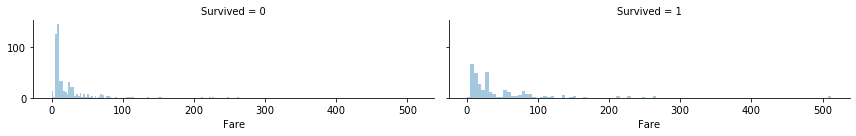

In [31]:
g = sns.FacetGrid(col="Survived", data=train_data, height = 2, aspect=3)
g.map(sns.distplot, "Fare", kde=False, bins=100)

Here we face the same issue as the age feature. To be more clear pandas.cut() or pandas.qcut() will be used to divide the fare into categories. Further study will be done on the Fare feature to decide which to use  pandas.cut() or pandas.qcut().

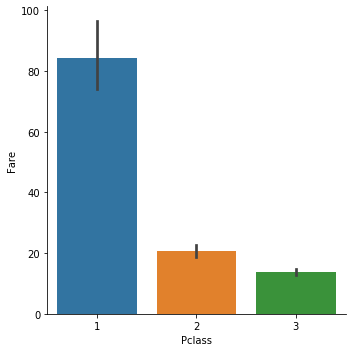

In [32]:
sns.catplot(x="Pclass", y="Fare", kind="bar", data=train_data)

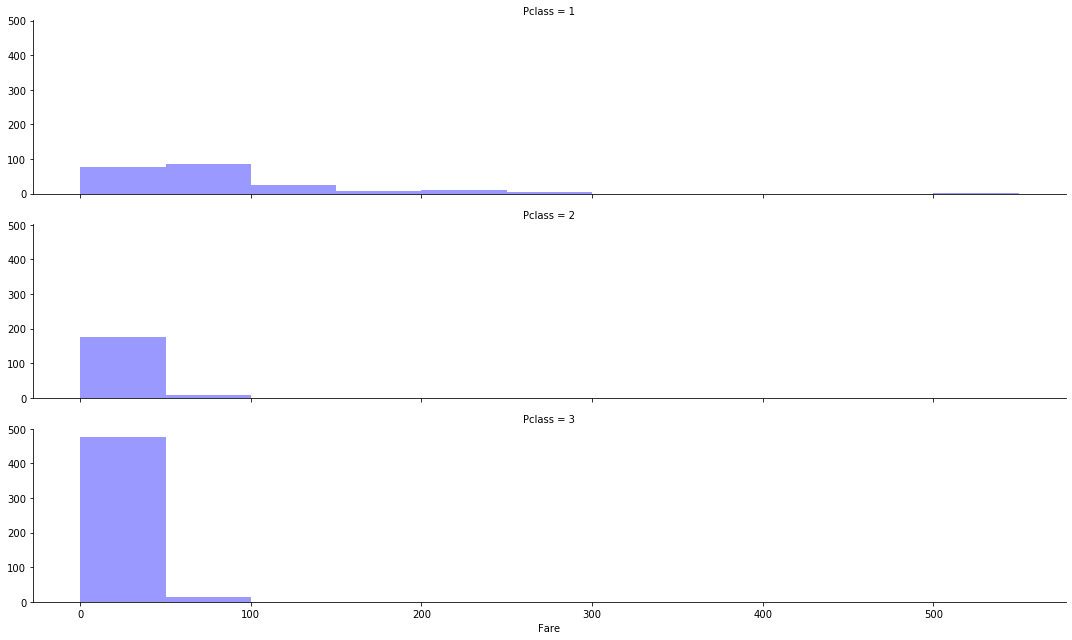

In [33]:
bins=np.arange(0, 600, 50)
g=sns.FacetGrid(row="Pclass", data=train_data, height = 3, aspect=5)
g.map(sns.distplot, "Fare", kde=False, bins=bins, color="b")

The values differ from what is expected, as there are people who are in Pclass 1 but paid low to no fare. This can be due to several reasons such as if the passenger is an employee or not.
Before dividing the fare, its relation with embarked port will be checked. And the relation of Embarked port with Pclass will also be checked.

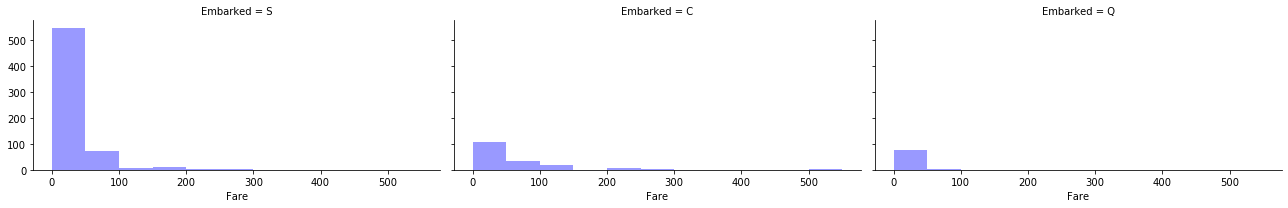

In [34]:
bins=np.arange(0, 600, 50)
g=sns.FacetGrid(col="Embarked", data=train_data, height = 3, aspect=2)
g.map(sns.distplot, "Fare", kde=False, bins=bins, color="b")

Individuals who embarked through port S paid the lowest fare.[](http://)

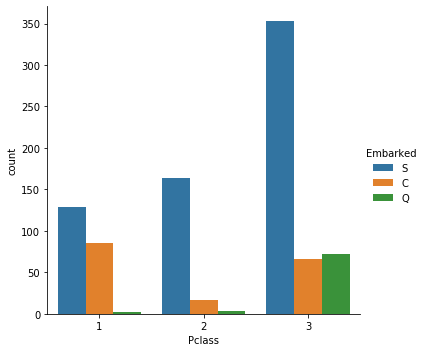

In [35]:
sns.catplot(x="Pclass", hue="Embarked", kind="count", data=train_data)

This explains why a high number of passengers who embarked from port S paid the low fares, as this port is mostly used by Pclass 3. It also showed the lowest survival mean. Port C showed passengers who paid higher fares, as it is mostly used by Pclass 1. Also, port C showed the highest survival mean. Port Q was embarked by individuals who paid low fares and mainly belonged to Pclass 3. But why did Port S show less survival mean than Port Q? This might be because Port S was used by most of the passengers (higher number of passengers embarked through this port).

In [36]:
#Check number of passengers who embarked at each port
print(train_data.loc[train_data["Embarked"]=="S"].PassengerId.value_counts().sum())
print(train_data.loc[train_data["Embarked"]=="Q"].PassengerId.value_counts().sum())
print(train_data.loc[train_data["Embarked"]=="C"].PassengerId.value_counts().sum())

646
77
168


In the test_data there is 1 empty value in the Fare feature. I will fill it with -1. 

In [37]:
test_data["Fare"] = test_data["Fare"].fillna(-1)

In [38]:
train_data["Fare"].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [39]:
test_data["Fare"].describe()

count    418.000000
mean      35.539564
std       55.869231
min       -1.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: Fare, dtype: float64

pandas.qcut() will be used to divide the Fare into four categories with equal distributions. pandas.cut() was not used since it is not clear how the fare was assigned and how it relates with other features. 

In [40]:
def qcut_fare(df, q, labels):
    df["Fare"]=pd.qcut(df["Fare"], q, labels=labels)
    return df

labels=["range1", "range2", "range3", "range4"]
train_data=qcut_fare(train_data, 4, labels)
test_data=qcut_fare(test_data, 4, labels)

The reason q=4 was used is becaused the data will be divided according to the values that .desctibe() show you (min, 25%, 50%, 75%, max)

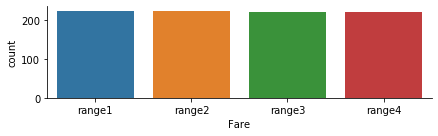

In [41]:
sns.catplot(x="Fare", data=train_data, kind="count", height=2, aspect=3)

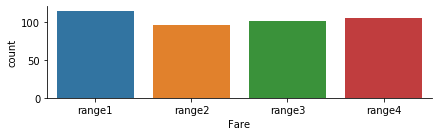

In [42]:
sns.catplot(x="Fare", data=test_data, kind="count", height=2, aspect=3)

In [43]:
train_data["Name"]

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

At the beginning I started with the assumption that the Name feature does not serve useful since every individual has a unique name. What is interesting here is that names have titles. These titles can be useful for the predictions.

In [44]:
train_data["Name"]=train_data["Name"].apply(lambda s: s.split(', ')[1].split('.')[0])
test_data["Name"]=test_data["Name"].apply(lambda s: s.split(', ')[1].split('.')[0])

In [45]:
train_data["Name"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [46]:
test_data["Name"].unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Ms', 'Col', 'Rev', 'Dr', 'Dona'],
      dtype=object)

In [47]:
train_data["Name"].value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Col               2
Mlle              2
Major             2
Jonkheer          1
Mme               1
Sir               1
Don               1
Lady              1
Ms                1
the Countess      1
Capt              1
Name: Name, dtype: int64

In [48]:
test_data["Name"].value_counts()

Mr        240
Miss       78
Mrs        72
Master     21
Col         2
Rev         2
Dr          1
Ms          1
Dona        1
Name: Name, dtype: int64

In [49]:
train_data["Name"]=train_data["Name"].replace(["Ms", "Mlle"], "Miss")
train_data["Name"]=train_data["Name"].replace(["Sir"], "Mr")
train_data["Name"]=train_data["Name"].replace(["Mme"], "Mrs")
train_data["Name"]=train_data["Name"].replace(["Dr", "Rev", "Col", "Major", "Capt", "Master", 
                                             "Lady", "the Countess", "Don", "Dona", "Jonkheer"], "Other")

In [50]:
test_data["Name"]=test_data["Name"].replace(["Ms", "Mlle"], "Miss")
test_data["Name"]=test_data["Name"].replace(["Sir"], "Mr")
test_data["Name"]=test_data["Name"].replace(["Mme"], "Mrs")
test_data["Name"]=test_data["Name"].replace(["Dr", "Rev", "Col", "Major", "Capt", "Master", 
                                             "Lady", "the Countess", "Don", "Dona", "Jonkheer"], "Other")

In [51]:
train_data["Name"].unique()

array(['Mr', 'Mrs', 'Miss', 'Other'], dtype=object)

In [52]:
train_data["Name"].value_counts()

Mr       518
Miss     185
Mrs      126
Other     62
Name: Name, dtype: int64

In [53]:
test_data["Name"].value_counts()

Mr       240
Miss      79
Mrs       72
Other     27
Name: Name, dtype: int64

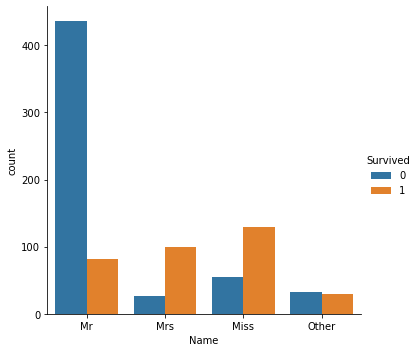

In [54]:
sns.catplot(x="Name", hue="Survived", kind="count", data=train_data)

In [55]:
train_data.Cabin.describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

In [56]:
train_data.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

At first I began with the idea of dropping the Cabin feature, as it has a lot of missing values. However, since I will be using Xgboost in my model, which is known to be good with dealing with missing values, I will make use of this feature. 

Instead of having a Cabin feature, a Deck feature will be created. Cabins were located on different decks on the ship. These decks were: A, B, C, D, E, F, G, T.

"Unknown" will designate NaN values.

In [57]:
train_data["Cabin"]=train_data["Cabin"].fillna("Unknown")

In [58]:
test_data["Cabin"]=test_data["Cabin"].fillna("Unknown")

In [59]:
train_data["Cabin"].unique()

array(['Unknown', 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62

In [60]:
test_data["Cabin"].unique()

array(['Unknown', 'B45', 'E31', 'B57 B59 B63 B66', 'B36', 'A21', 'C78',
       'D34', 'D19', 'A9', 'D15', 'C31', 'C23 C25 C27', 'F G63', 'B61',
       'C53', 'D43', 'C130', 'C132', 'C101', 'C55 C57', 'B71', 'C46',
       'C116', 'F', 'A29', 'G6', 'C6', 'C28', 'C51', 'E46', 'C54', 'C97',
       'D22', 'B10', 'F4', 'E45', 'E52', 'D30', 'B58 B60', 'E34',
       'C62 C64', 'A11', 'B11', 'C80', 'F33', 'C85', 'D37', 'C86', 'D21',
       'C89', 'F E46', 'A34', 'D', 'B26', 'C22 C26', 'B69', 'C32', 'B78',
       'F E57', 'F2', 'A18', 'C106', 'B51 B53 B55', 'D10 D12', 'E60',
       'E50', 'E39 E41', 'B52 B54 B56', 'C39', 'B24', 'D28', 'B41', 'C7',
       'D40', 'D38', 'C105'], dtype=object)

In [61]:
train_data["Deck"]=train_data["Cabin"].str.replace("([0-9\s])+","")

In [62]:
test_data["Deck"]=test_data["Cabin"].str.replace("([0-9\s])+","")

In [63]:
test_data["Deck"].value_counts()

Unknown    327
C           29
D           12
B           12
E            8
A            7
F            5
CC           4
BBBB         3
FE           2
CCC          2
BBB          2
BB           1
DD           1
EE           1
G            1
FG           1
Name: Deck, dtype: int64

In [64]:
train_data["Deck"].value_counts()

Unknown    687
C           51
B           36
D           32
E           32
A           15
F            9
BB           7
G            4
CCC          4
CC           4
FG           3
BBB          2
BBBB         2
T            1
FE           1
DD           1
Name: Deck, dtype: int64

The data reveals that some passangers had more than one cabin. Some of them were on the same deck and some were on different decks. To deal with this, a new feature will be created that indicates the total number of cabins per passenger. If the passenger's cabin is unknown it will give 0. For decks which consitute of more than one letter, the first letter will be taken.

In [65]:
def total_cabins(row):
    if row.Deck == "Unknown":
        row["TotalCab"] = 0
    elif len(row.Deck) > 1:
        row["TotalCab"] = len(row.Deck)
    else:
        row["TotalCab"] = 1
    return row

train_data=train_data.apply(total_cabins, axis=1)
test_data=test_data.apply(total_cabins,axis=1)
        

In [66]:
train_data["TotalCab"].value_counts()

0    687
1    180
2     16
3      6
4      2
Name: TotalCab, dtype: int64

In [67]:
test_data["TotalCab"].value_counts()

0    327
1     74
2     10
3      4
4      3
Name: TotalCab, dtype: int64

In [68]:
train_data["Deck"]=train_data["Deck"].apply(lambda s: s[0] if s != "Unknown" else s)

In [69]:
test_data["Deck"]=test_data["Deck"].apply(lambda s: s[0] if s != "Unknown" else s)

In [70]:
test_data["Deck"].value_counts()

Unknown    327
C           35
B           18
D           13
E            9
F            8
A            7
G            1
Name: Deck, dtype: int64

In [71]:
train_data["Deck"].value_counts()

Unknown    687
C           59
B           47
D           33
E           32
A           15
F           13
G            4
T            1
Name: Deck, dtype: int64

In [72]:
train_data=train_data.drop(["Survived", "Cabin", "Ticket"], axis=1)
test_data=test_data.drop(["Cabin", "Ticket"], axis=1)

In [73]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  891 non-null    int64 
 1   Pclass       891 non-null    int64 
 2   Name         891 non-null    object
 3   Sex          891 non-null    object
 4   Age          891 non-null    object
 5   Fare         891 non-null    object
 6   Embarked     891 non-null    object
 7   FamMembs     891 non-null    object
 8   Deck         891 non-null    object
 9   TotalCab     891 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 69.7+ KB


In [74]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   PassengerId  418 non-null    int64 
 1   Pclass       418 non-null    int64 
 2   Name         418 non-null    object
 3   Sex          418 non-null    object
 4   Age          418 non-null    object
 5   Fare         418 non-null    object
 6   Embarked     418 non-null    object
 7   FamMembs     418 non-null    object
 8   Deck         418 non-null    object
 9   TotalCab     418 non-null    int64 
dtypes: int64(3), object(7)
memory usage: 32.8+ KB


# Deal with categorical values

In [75]:

from sklearn.preprocessing import OneHotEncoder

OHE = OneHotEncoder(handle_unknown='ignore', sparse=False)

features = ["Pclass", "Name", "Sex", "Age", "Fare", "Embarked", "FamMembs", "Deck", "TotalCab"]
OHE_train_cols = pd.DataFrame(OHE.fit_transform(train_data[features]))
OHE_test_cols = pd.DataFrame(OHE.transform(test_data[features]))

OHE_train_cols.index = train_data.index
OHE_test_cols.index = test_data.index

num_train=train_data.drop(features, axis=1)
num_test=test_data.drop(features, axis=1)

train_data = pd.concat([num_train, OHE_train_cols], axis=1)
test_data = pd.concat([num_test, OHE_test_cols], axis=1)


In [76]:
print(train_data.shape, test_data.shape)

(891, 42) (418, 42)


# XGBoost Parameter Tuning & RandomizedSearchCV

In [77]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
xgb=XGBClassifier(objective='reg:logistic')

params={
    'n_estimators': [200, 500, 1000],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [5, 7, 9],
    'colsample_bytree': [ 0.4, 0.6, 0.8],
    'subsample': [0.8, 0.9, 1],
    'gamma': [0, 0.5, 1]
}

clf=RandomizedSearchCV(xgb, param_distributions=params, n_iter=50, n_jobs=-1, verbose=1)
clf.fit(train_data, y)



Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  1.4min finished


RandomizedSearchCV(cv=None, error_score=nan,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, gamma=None,
                                           gpu_id=None, importance_type='gain',
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constraints=Non...
                                           validate_parameters=False,
                                           verbosity=None),
                   iid='deprecated', n_iter=50, n_jobs=-1,
                   param_distributi

In [78]:
score=clf.best_score_
params=clf.best_params_
print("Best score: ",score)
print("Best parameters: ", params)

Best score:  0.8181909484652564
Best parameters:  {'subsample': 1, 'n_estimators': 200, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0, 'colsample_bytree': 0.4}
